In [1]:
from DCLNet.detect import resize_img, get_score, restore_bboxes
from DCLNet.config import cfg
import os, glob, random, json
import numpy as np, cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [2]:
def convert_from_cv2_to_image(img: np.ndarray) -> Image:
    # return Image.fromarray(img)
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    # return np.asarray(img)
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

In [3]:
import re

exclude_patterns = [re.compile(pattern) for pattern in map(re.escape, ['Mujarobat Kubro/Image (38).bmp'])]
dataset_path = '/home/yakkov/progs/ac/pegon-annotated-dataset-images-only/'
image_paths = glob.glob(os.path.join(dataset_path, '**', '*.bmp'), recursive=True)
image_paths = [path for path in image_paths if not any(pattern.search(path) for pattern in exclude_patterns)]

image_path = random.choice(image_paths)

In [4]:
len(image_paths)

113

In [5]:
middle_line = 1575
edge_line = 3250

In [6]:
import torch
from DCLNet.model import ResNetUNet
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(backbone='50')
model.to(device)
model.eval()
model_pth = './DCLNet/pths/train/model_epoch_150.pth'
model.load_state_dict(torch.load(model_pth))

<All keys matched successfully>

In [7]:
def infer(img, model, short_side, device):
    res = dict()
    res['origin_h'] = img.height
    res['origin_w'] = img.width
    img = resize_img(img, short_side)
    res['resize_h'] = img.height
    res['resize_w'] = img.width
    cls, rho, theta = get_score(img, model, device)
    res['cls'] = cls
    res['rho'] = rho
    res['theta'] = theta
    return res

In [8]:
def minmax(it):
    min = max = None
    for val in it:
        if min is None or val < min:
            min = val
        if max is None or val > max:
            max = val
    return min, max

In [9]:
class CumulativeBox:
    def __init__(self, coordinates, conf=None):
        self.coordinates = coordinates
        (x1, y1), (x2, y2), (x3, y3), (x4, y4) = self.coordinates
        self.left, self.right = minmax([x1, x2, x3, x4])
        self.top, self.bottom = minmax([y1, y2, y3, y4])
        self.conf = conf

    def x_linked(self, other, tol=5):
        return abs(self.left - other.right) <= tol or abs(self.right - other.left) <= tol
    
    def y_linked(self, other, tol=5):
        return abs(self.top - other.bottom) <= tol or abs(self.bottom - other.top) <= tol
    
    def x_within(self, other):
        return self.left > other.left and self.right < other.right

    def y_within(self, other):
        return self.top > other.top and self.bottom < other.bottom
    
    def x_iou(self, other):
        left, x_inter1 = minmax((self.left, other.left))
        x_inter2, right = minmax((self.right, other.right))
        width_inter = x_inter2 - x_inter1
        width1 = self.right - self.left
        width2 = other.right - other.left
        return width_inter / (right-left)
    
    def y_iou(self, other):
        top, y_inter1 = minmax((self.top, other.top))
        y_inter2, bottom = minmax((self.bottom, other.bottom))
        height_inter = y_inter2 - y_inter1
        height1 = self.bottom - self.top
        height2 = other.bottom - other.top
        return height_inter / (bottom-top)
    
    def __lt__(self, other):
        # Compare based on y-coordinate
        if self.top < other.top:
            return True
        elif self.top > other.top:
            return False

        # If y-coordinates are equal, compare based on x-coordinate
        if self.left < other.left:
            return True
        else:
            return False
        
    def combine(self, other):
        if self.conf != None and other.conf != None:
            area1 = (self.bottom-self.top) * (self.right-self.left)
            area2 = (other.bottom-other.top) * (other.right-other.left)
            self.conf = ((self.conf * area1) + (other.conf * area2)) / (area1+area2)
        if self.conf == None and other.conf != None:
            self.conf = other.conf
        self.left = min(self.left, other.left)
        self.right = max(self.right, other.right)
        self.top = min(self.top, other.top)
        self.bottom = max(self.bottom, other.bottom)
        
    def __repr__(self):
        return f'CumulativeBox(coordinates={self.left},{self.right},{self.top},{self.bottom},conf={self.conf})'
        
    def box_points(self):
        return [(self.left, self.top), (self.right, self.bottom)]

In [10]:
import copy
def combine_to_lines(column, gamma=0.5):
    lines = [copy.deepcopy(column[0])]
    for i, box in enumerate(column[1:], start=1):
        assigned = False
        for j, line in enumerate(lines):
            if box.y_iou(line) > gamma or (box.y_within(line) and box.x_within(line)):
                line.combine(copy.deepcopy(box))
                assigned = True
                break
        if not assigned:
            lines.append(copy.deepcopy(box))
    return lines

In [11]:
def res_to_lines(res, prob_thresh, gamma, xshift=0, yshift=0):
    bboxes = restore_bboxes(res['cls'], res['rho'], res['theta'], prob_thresh)
    vertices = []
    confs = []
    for bbox in bboxes:
        pts = bbox[:8].reshape((4,2)) * 4 * (res['origin_w'] / res['resize_w'] + res['origin_h'] / res['resize_h']) / 2 
        vertices.append(pts)
        confs.append(bbox[8])
    
    if len(vertices) > 0:
        vertices = np.array(vertices)
        vertices[:,:,0] += xshift
        vertices[:,:,1] += yshift
    else:
        return vertices
    
    pred_boxes = []
    for vertex, conf in zip(vertices, confs):
        cords = vertex.astype(int)
        pred_boxes.append(CumulativeBox(cords, conf=conf))
    lines = combine_to_lines(sorted(pred_boxes), gamma=gamma)
    return lines, pred_boxes

In [12]:
def process_two_pages(img, model, middle_line, edge_line,
                      short_side, device, thresholds=(0.8, 0.85, 0.1),
                      gamma=0.5):
    l_img = img.crop((0, 0, middle_line, img.height))
    r_img = img.crop((middle_line, 0, edge_line, img.height))
    
    l_res = infer(l_img, model, cfg.test.short_side, device)
    r_res = infer(r_img, model, cfg.test.short_side, device)
    
    ret = dict()
    for thresh in thresholds:
        l_lines, l_polygons = res_to_lines(l_res, thresh, gamma)
        r_lines, r_polygons = res_to_lines(r_res, thresh, gamma, xshift=middle_line)
        
        ret[thresh] = {'lines': l_lines + r_lines, 'polygons': l_polygons + r_polygons}
        
    return ret

In [13]:
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    left, x_inter1 = minmax((x1, x3))
    x_inter2, right = minmax((x2, x4))
    width_inter = x_inter2 - x_inter1
    width1 = x2 - x1
    width2 = x4 - x3
    
    top, y_inter1 = minmax((y1, y3))
    y_inter2, bottom = minmax((y2, y4))
    height_inter = y_inter2 - y_inter1
    height1 = y2 - y1
    height2 = y4 - y3
    
    area1 = width1 * height1
    area2 = width2 * height2
    
    area_inter = width_inter * height_inter
    
    area_union = area1 + area2 - area_inter
    
    return (-1 if height_inter < 0 or width_inter < 0 else 1) * abs(area_inter/area_union)

def calculate_y_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    
    top, y_inter1 = minmax((y1, y3))
    y_inter2, bottom = minmax((y2, y4))
    height_inter = y_inter2 - y_inter1
    height1 = y2 - y1
    height2 = y4 - y3
    
    return height_inter / (bottom-top)

def evaluate(predicted_boxes, ground_truth_boxes, iou_threshold=0.5, iou_calculator=calculate_iou):
    num_predictions = len(predicted_boxes)
    num_ground_truths = len(ground_truth_boxes)
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    # Lists to keep track of matched predictions and ground truths
    matched_predictions = set()
    matched_ground_truths = set()

    for i in range(num_predictions):
        max_iou = 0.0
        max_index = -1

        for j in range(num_ground_truths):
            iou = iou_calculator(predicted_boxes[i], ground_truth_boxes[j])

            if iou > max_iou:
                max_iou = iou
                max_index = j

        if max_iou >= iou_threshold and max_index not in matched_ground_truths:
            tp += 1
            matched_predictions.add(i)
            matched_ground_truths.add(max_index)
        else:
            fp += 1

    fn = num_ground_truths - len(matched_ground_truths)
    return {'tp': tp, 'fp': fp, 'fn': fn}

In [14]:
def metrics(tp, fp, fn, betas=[1]):
    res = {}
    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = tp / (tp + fn)
    except ZeroDivisionError:
        recall = 0
    res['precision'] = precision
    res['recall'] = recall
    for beta in betas:
        try:
            res[f'f{beta}'] = (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))
        except ZeroDivisionError:
            res[f'f{beta}'] = 0
    return res

In [15]:
def draw_boxes_on_image(img, boxes, plot_numbers=False, color=(255,0,0)):  
    for i, box_pt in enumerate(boxes):
        img = cv2.rectangle(img, *box_pt, color, 3)
        if plot_numbers:
            # Write the text near the bounding box
            text = str(i)  # The number to display
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            font_thickness = 4
            text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)

            # Calculate the position for the text
            org = (box_pt[0][0], box_pt[1][1])

            # Draw the text on the image
            img = cv2.putText(img, text, org, font, font_scale, color, font_thickness, cv2.LINE_AA)
    return img

In [16]:
image_path = os.path.join(dataset_path, 'Majmuah Syariah/Image (62).bmp')
img = Image.open(image_path).convert('RGB')

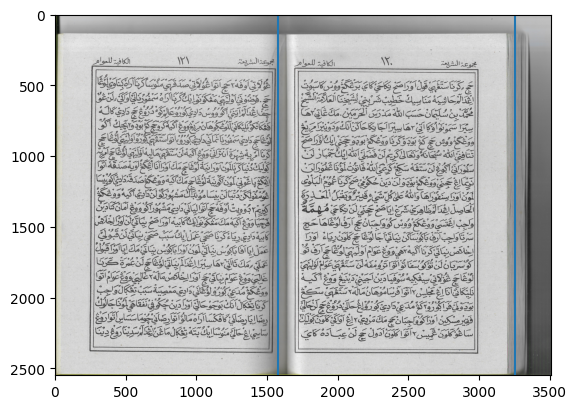

In [17]:
plt.imshow(img)
plt.axvline(middle_line)
plt.axvline(edge_line)
plt.show()

In [18]:
%%time
res = process_two_pages(img, model, middle_line, edge_line, cfg.test.short_side, device, gamma=0.4)

CPU times: user 11.4 s, sys: 326 ms, total: 11.7 s
Wall time: 13.5 s


In [19]:
lines = res[0.85]['lines']
polygons = res[0.85]['polygons']

In [20]:
preds = np.array([[line.left, line.top, line.right, line.bottom, 0, line.conf] for line in lines])

In [21]:
# poly_im = cv2.polylines(convert_from_image_to_cv2(img),np.array([p.coordinates.reshape((-1,1,2)) for p in polygons]),True,(0,215,255),3)
# plt.imshow(poly_im)
# plt.show()

In [22]:
# cv2.imwrite('polygon image.png', poly_im)

In [24]:
line_im.shape

(2550, 3507, 3)

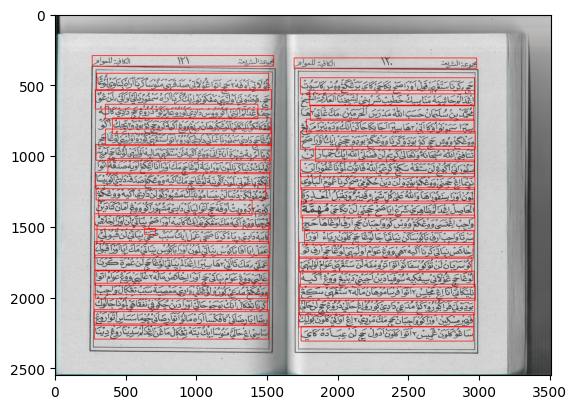

In [26]:
line_im = convert_from_image_to_cv2(img)

draw_boxes_on_image(line_im, preds[:,:4].reshape(-1, 2, 2).astype(int), color=(255, 0, 0))
cv2.imwrite('res-dclnet-comp.png', cv2.cvtColor(line_im, cv2.COLOR_BGR2RGB))
plt.imshow(line_im)
plt.show()

In [24]:
gt_filepath = image_path.replace('.bmp', '.json').replace('-images-only', '')
gt = []
for shape in json.load(open(gt_filepath))['shapes']:
    ((x1, y1), (x2, y2)) = shape['points']
    left, right = minmax((x1, x2))
    top, bottom = minmax((y1, y2))
    gt.append([left, top, right, bottom, 0, 0, 0])
gt = np.array(gt)

In [25]:
res = evaluate(preds[:,:4], gt[:,:4], iou_threshold=0.5)
metrics(res['tp'], res['fp'], res['fn'])

{'precision': 0.9230769230769231,
 'recall': 0.46153846153846156,
 'f1': 0.6153846153846155}

In [26]:
before = preds[:,:4]

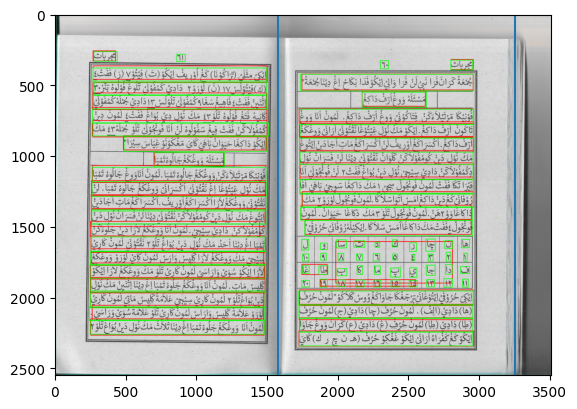

In [27]:
img_ = convert_from_image_to_cv2(img)

draw_boxes_on_image(img_, preds[:,:4].reshape(-1, 2, 2).astype(int), color=(255, 0, 0))
draw_boxes_on_image(img_, gt[:,:4].reshape(-1, 2, 2).astype(int), color=(0, 255, 0))
plt.imshow(img_)
plt.axvline(middle_line)
plt.axvline(edge_line)
plt.show()

In [28]:
input_path = 'input/'

gt_filepath = image_path.replace('.bmp', '.json').replace('-images-only', '')
gt_path = os.path.join(input_path, 'ground-truth', image_path.replace(dataset_path, '').strip('/').replace('/', '_').replace('.bmp', '.txt'))
detection_path = gt_path.replace('ground-truth', 'detection-results')
os.makedirs(os.path.dirname(detection_path), exist_ok=True)
with open(detection_path, 'w') as f:
    f.write('\n'.join([f'{conf} {left} {top} {right} {bottom}' for left, top, right, bottom, _, conf in preds]))

pred_file = image_path.replace(dataset_path, 'input/detection-results/').replace('/Image', '_Image').replace('.bmp', '.txt')
gt_file = image_path.replace(dataset_path, 'input/ground-truth/').replace('/Image', '_Image').replace('.bmp', '.txt')
preds = np.array(list(map(lambda x:tuple(map(float, x.split())), open(pred_file).readlines())))
gt = np.array(list(map(lambda x:tuple(map(float, x.split())), open(gt_file).readlines())))

draw_boxes_on_image(img_, preds[:,1:].reshape(-1, 2, 2).astype(int), color=(255, 0, 0))
draw_boxes_on_image(img_, gt[:,:4].reshape(-1, 2, 2).astype(int), color=(0, 255, 0))
plt.imshow(img_)
plt.axvline(middle_line)
plt.axvline(edge_line)
plt.show()

NameError: name 'input_path' is not defined

In [ ]:
after = preds[:,1:]

In [ ]:
(before == after).all()

In [29]:
from tqdm import tqdm

In [16]:
for image_path in tqdm(image_paths):
    gt_filepath = image_path.replace('.bmp', '.json').replace('-images-only', '')
    gt = []
    for shape in json.load(open(gt_filepath))['shapes']:
        ((x1, y1), (x2, y2)) = shape['points']
        left, right = minmax((x1, x2))
        top, bottom = minmax((y1, y2))
        gt.append([left, top, right, bottom, 0, 0, 0])
    gt = np.array(gt)
    
    gt_path = os.path.join(input_path, 'ground-truth', image_path.replace(dataset_path, '').strip('/').replace('/', '_').replace('.bmp', '.txt'))
    os.makedirs(os.path.dirname(gt_path), exist_ok=True)
    with open(gt_path, 'w') as f:
        f.write('\n'.join([f'{left} {top} {right} {bottom}' for left, top, right, bottom, _, _, _ in gt]))

100%|█████████████████████████████████████████| 113/113 [00:13<00:00,  8.17it/s]


In [26]:
for image_path in tqdm(image_paths):
    img = Image.open(image_path).convert('RGB')
    lines = process_two_pages(img, model, middle_line, edge_line, cfg.test.short_side, device, gamma=0.4)
    preds = np.array([[line.left, line.top, line.right, line.bottom, 0, line.conf] for line in lines[0.85]])
    gt_filepath = image_path.replace('.bmp', '.json').replace('-images-only', '')
    gt_path = os.path.join(input_path, 'ground-truth', image_path.replace(dataset_path, '').strip('/').replace('/', '_').replace('.bmp', '.txt'))
    detection_path = gt_path.replace('ground-truth', 'detection-results')
    os.makedirs(os.path.dirname(detection_path), exist_ok=True)
    with open(detection_path, 'w') as f:
        f.write('\n'.join([f'{conf} {left} {top} {right} {bottom}' for left, top, right, bottom, _, conf in preds]))

100%|█████████████████████████████████████████| 113/113 [23:25<00:00, 12.44s/it]


In [37]:
pred_files = glob.glob('input/detection-results/**/*.txt', recursive=True)
res = {'tp': 0, 'fp': 0, 'fn': 0}
full_res = {}

for pred_file in tqdm(pred_files):
    gt_file = pred_file.replace('detection-results', 'ground-truth')
    preds = np.array(list(map(lambda x:tuple(map(float, x.split())), open(pred_file).readlines())))
    gt = np.array(list(map(lambda x:tuple(map(float, x.split())), open(gt_file).readlines())))
    try:
        res_ = evaluate(preds[:,1:], gt, iou_threshold=0.5,
                        iou_calculator=calculate_y_iou)
    except:
        print(gt_filepath)
        raise
    res['tp'] += res_['tp']
    res['fp'] += res_['fp']
    res['fn'] += res_['fn']
    full_res[os.path.basename(pred_file).replace('.txt', '.bmp').replace('_', '/')] = metrics(res_['tp'], res_['fp'], res_['fn'])
metrics(res['tp'], res['fp'], res['fn'])

100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 181.89it/s]


{'precision': 0.7977637335926105,
 'recall': 0.7799429657794676,
 'f1': 0.7887527036770007}

In [18]:
lowest = sorted(full_res.items(), key=lambda x:x[1]['f1'])

In [19]:
def show_preds_and_gt(image_path):
    pred_file = '_'.join(os.path.split(image_path)).replace(dataset_path, 'input/detection-results/').replace('.bmp', '.txt')
    gt_file = '_'.join(os.path.split(image_path)).replace(dataset_path, 'input/ground-truth/').replace('.bmp', '.txt')
    preds = np.array(list(map(lambda x:tuple(map(float, x.split())), open(pred_file).readlines())))
    gt = np.array(list(map(lambda x:tuple(map(float, x.split())), open(gt_file).readlines())))

    img = cv2.imread(image_path)

    draw_boxes_on_image(img, preds[:,1:].reshape(-1, 2, 2).astype(int), color=(255, 0, 0))
    draw_boxes_on_image(img, gt[:,:4].reshape(-1, 2, 2).astype(int), color=(0, 255, 0))
    plt.imshow(img)
    plt.axvline(middle_line)
    plt.axvline(edge_line)
    return img

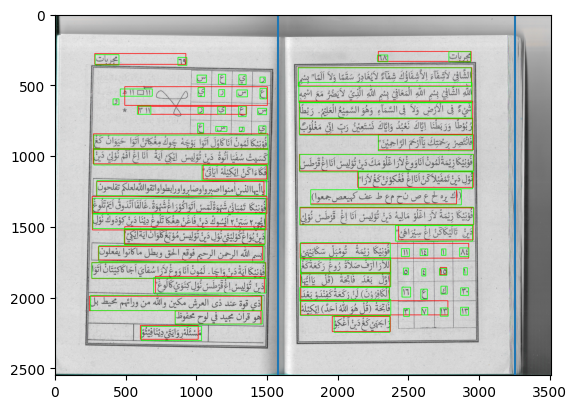

In [25]:
cv2.imwrite('ex0.png', show_preds_and_gt(os.path.join(dataset_path, lowest[0][0]))); plt.show()

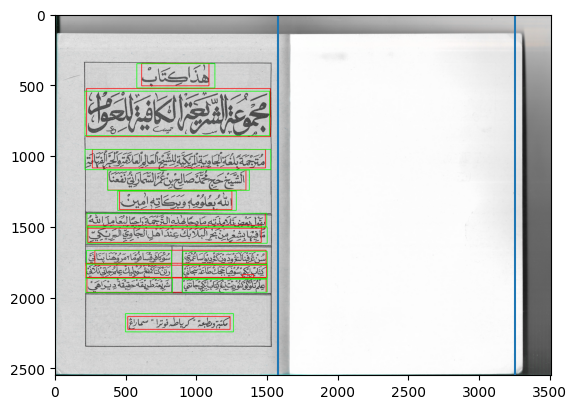

In [26]:
cv2.imwrite('ex1.png', show_preds_and_gt(os.path.join(dataset_path, lowest[1][0]))); plt.show()

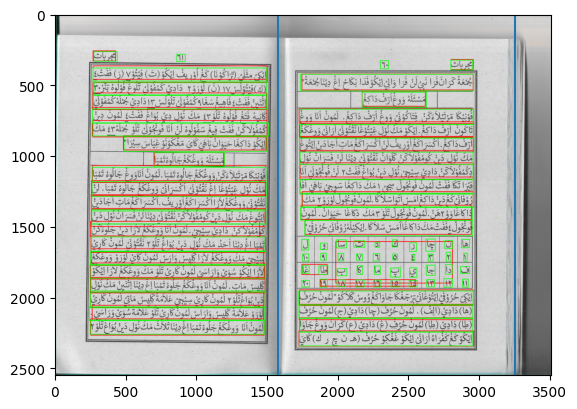

In [27]:
cv2.imwrite('ex2.png', show_preds_and_gt(os.path.join(dataset_path, lowest[2][0]))); plt.show()

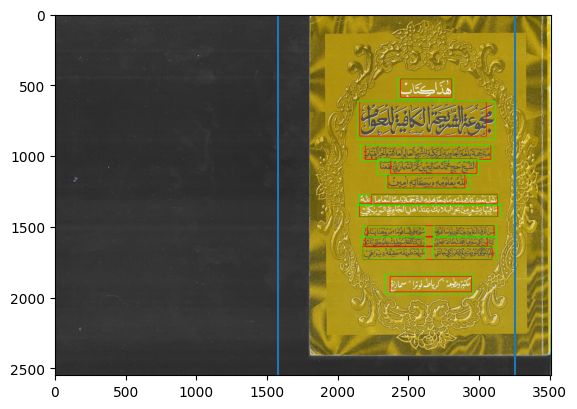

In [28]:
cv2.imwrite('ex3.png', show_preds_and_gt(os.path.join(dataset_path, lowest[3][0]))); plt.show()

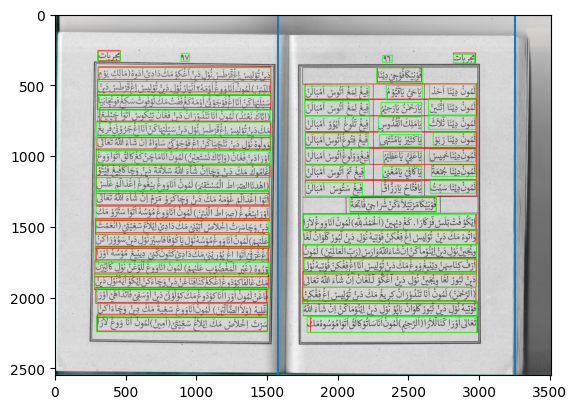

In [30]:
cv2.imwrite('ex4.png', show_preds_and_gt(os.path.join(dataset_path, lowest[4][0]))); plt.show()